# Fushion of IMU and Audio features

## Training on augmented datasets: 1000ms augmentation case.
- Training is done by including: 1-shift (50ms), 2-shifts (100ms), 10-shifts (500ms), 20-shifts (1000ms)

## IMU and Audio data is concatenated at an intermediate layer and then prediction is made

In [1]:
import numpy as np
import scipy.io

from keras import optimizers
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint


import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Activation
from keras.layers.core import Permute, Reshape
from keras import backend as K

from matplotlib import pyplot as plt
from PIL import Image as img_PIL


# random seed.
rand_seed = 2

from numpy.random import seed
seed(rand_seed)
from tqdm.keras import TqdmCallback
import tensorflow
tensorflow.random.set_seed(rand_seed)

In [2]:
def one_hot_encoding(y_data):
    Mapping=dict()
    sub_dirs=['downstair','upstair','run','jump','walk','handwashing','exercise']

    categories=7

    count=0
    for i in sub_dirs:
        Mapping[i]=count
        count=count+1

    y_features2=[]
    for i in range(len(y_data)):
        Type=y_data[i]
        lab=Mapping[Type]
        y_features2.append(lab)

    y_features=np.array(y_features2)
    y_features=y_features.reshape(y_features.shape[0],1)
    from keras.utils import to_categorical
    y_features = to_categorical(y_features)

    return y_features

In [3]:
path='C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/data/'
pathAug='E:/augmented_data/'

def get_train_and_validate_data(path=path):
    Train_data = np.load(path+'Data_train_all.npz')
    Train_data=np.load(path+'train_5000.npz')
    Features_imu=np.asarray(Train_data['arr_0'],dtype=np.float64)
    Labels=Train_data['arr_1']
    Features_audio=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    
    randomize = np.arange(len(Labels))
    np.random.shuffle(randomize)
    
    Labels = Labels[randomize]
    Features_audio = Features_audio[randomize]
    Features_imu = Features_imu[randomize]
    
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    new_Labels = np.split(Labels,[Labels.shape[0] - 2000])
    new_Features_audio = np.split(Features_audio,[Features_audio.shape[0] - 2000])
    Features_imu = np.split(Features_imu,[Features_imu.shape[0] - 2000])
    
    return new_Labels[0],new_Features_audio[0],Features_imu[0],new_Labels[1],new_Features_audio[1],Features_imu[1]


def get_test_data(path=path):
    Train_data = np.load(path+'Data_test_71.pkl',allow_pickle=True)
    Labels = Train_data[1]
    Features_audio = Train_data[2]
    Features_imu = np.asarray(Train_data[0],dtype=np.float64)

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 
    
    return Labels,Features_audio,Features_imu

In [4]:
Labels,Features_audio,Features_imu,Labels2,Features_audio2,Features_imu2 = get_train_and_validate_data()
print(Labels.shape,Features_audio.shape,Features_imu.shape)
print('Train Classes distribution: ',np.sum(Labels, axis = 0))

print(Labels2.shape,Features_audio2.shape,Features_imu2.shape)
print('Validate Classes distribution: ',np.sum(Labels2, axis = 0))

Labels3,Features_audio3,Features_imu3 = get_test_data()
print(Labels3.shape,Features_audio3.shape,Features_imu3.shape)
print('Test Classes distribution: ',np.sum(Labels3, axis = 0))

(3000, 7) (3000, 193) (3000, 1, 40, 12)
Train Classes distribution:  [440. 626. 324. 458. 326. 434. 392.]
(2000, 7) (2000, 193) (2000, 1, 40, 12)
Validate Classes distribution:  [320. 368. 222. 322. 206. 298. 264.]
(1377, 7) (1377, 193) (1377, 1, 40, 12)
Test Classes distribution:  [219. 268. 124. 146. 143. 234. 243.]


In [5]:
def get_train_data2(path,file):
    Train_data=np.load(path+file)
    Features_imu=np.asarray(Train_data['arr_0'],dtype=np.float64)
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']
    return Features_imu,Labels,Features_sound


In [6]:
Features_imu_1,Labels_1,Features_sound_1 = get_train_data2(pathAug,'train_data_1_shift.npz')
print(Features_imu_1.shape, Labels_1.shape, Features_sound_1.shape)
print('Train Classes distribution: ',np.sum(Labels_1, axis =0))

(9975, 1, 40, 12) (9975, 7) (9975, 193)
Train Classes distribution:  [1539. 1971. 1089. 1510. 1044. 1489. 1333.]


In [7]:
Features_imu_2,Labels_2,Features_sound_2 = get_train_data2(pathAug,'train_data_2_shift.npz')
print(Features_imu_2.shape, Labels_2.shape, Features_sound_2.shape)
print('Train Classes distribution: ',np.sum(Labels_2, axis =0))

(9975, 1, 40, 12) (9975, 7) (9975, 193)
Train Classes distribution:  [1539. 1971. 1089. 1510. 1044. 1489. 1333.]


In [8]:
Features_imu_10,Labels_10,Features_sound_10 = get_train_data2(pathAug,'train_data_10_shift.npz')
print(Features_imu_10.shape, Labels_10.shape, Features_sound_10.shape)
print('Train Classes distribution: ',np.sum(Labels_10, axis =0))

(9975, 1, 40, 12) (9975, 7) (9975, 193)
Train Classes distribution:  [1539. 1971. 1089. 1510. 1044. 1489. 1333.]


In [9]:
Features_imu_20,Labels_20,Features_sound_20 = get_train_data2(pathAug,'train_data_20_shift.npz')
print(Features_imu_20.shape, Labels_20.shape, Features_sound_20.shape)
print('Train Classes distribution: ',np.sum(Labels_20, axis =0))

(9975, 1, 40, 12) (9975, 7) (9975, 193)
Train Classes distribution:  [1539. 1971. 1089. 1510. 1044. 1489. 1333.]


# Make augmented Training Data

In [10]:
Features_imu = np.concatenate((Features_imu,Features_imu_1,Features_imu_2,Features_imu_10,Features_imu_20),axis=0)
Features_imu.shape

(42900, 1, 40, 12)

In [11]:
Labels = np.concatenate((Labels,Labels_1,Labels_2,Labels_10,Labels_20),axis=0)
Labels.shape

(42900, 7)

In [12]:
Features_sound = np.concatenate((Features_audio,Features_sound_1,Features_sound_2,Features_sound_10,Features_sound_20),axis=0)
Features_sound.shape

(42900, 193)

In [13]:
model_path = 'C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models/imu_audio_combined_model_shift_checkpoint'

# Combined Model: Audio + IMU

In [14]:
input_audio = keras.layers.Input(shape=(193,))
A1 = keras.layers.Dense(256, activation='relu')(input_audio)
A2 = keras.layers.Dense(256, activation='relu')(A1)
D1 = keras.layers.Dropout(0.3)(A2)
A5 = keras.layers.Dense(128, activation='relu')(D1)



num_feat_map=32
_, dim, win_len, _, = Features_imu.shape
input_imu = keras.layers.Input(shape=(dim, win_len, 12))

I1 = keras.layers.Conv2D(num_feat_map, kernel_size=(1, 5),
                 activation='relu',
                 padding='same')(input_imu)
I2=keras.layers.MaxPooling2D(pool_size=(1, 2))(I1)

I3 = keras.layers.Conv2D(num_feat_map, kernel_size=(1, 5),
                 activation='relu',
                 padding='same')(I2)
I4=keras.layers.MaxPooling2D(pool_size=(1, 2))(I3)
I5=keras.layers.Flatten()(I4)

I6= keras.layers.Dense(256, activation='relu')(I5)
D2 = keras.layers.Dropout(0.3)(I6)

I7= keras.layers.Dense(128, activation='relu')(D2)


# equivalent to added = keras.layers.add([x1, x2])
C1 =keras.layers.concatenate([A5, I7], axis=-1)


C3= keras.layers.Dense(64, activation='relu')(C1)

out = keras.layers.Dense(7, activation='softmax')(C3)

model = keras.models.Model(inputs=[input_audio, input_imu], outputs=out)
#model = keras.models.Model(inputs=input_audio, outputs=out)


In [15]:
#model.summary()

In [16]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

checkpointer = ModelCheckpoint(filepath=model_path, verbose=1,monitor='val_accuracy' ,save_best_only=True, save_weights_only=False)
earlystopper = EarlyStopping(monitor='val_accuracy',patience=5)

In [17]:
batch_size = 128
epochs = 100
from keras import optimizers
from keras.optimizers import Adam

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= adam,
              metrics=['accuracy'])

import time
start_time = time.time()

learning_hist = model.fit([Features_sound,Features_imu], Labels,
                    verbose=0,
                    epochs=epochs,
                        shuffle=True,
                    batch_size=batch_size,
                        callbacks=[checkpointer,earlystopper,TqdmCallback(verbose=2)],
                    validation_data=([Features_audio2,Features_imu2], Labels2)
                         
                         )

end_time = time.time()

print("---Time %s seconds ---" % (end_time - start_time))

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/336 [00:00<?, ?batch/s]


Epoch 00001: val_accuracy improved from -inf to 0.91000, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_shift_checkpoint
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_shift_checkpoint\assets


  0%|          | 0.00/336 [00:00<?, ?batch/s]


Epoch 00002: val_accuracy improved from 0.91000 to 0.93500, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_shift_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_shift_checkpoint\assets


  0%|          | 0.00/336 [00:00<?, ?batch/s]


Epoch 00003: val_accuracy improved from 0.93500 to 0.95900, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_shift_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_shift_checkpoint\assets


  0%|          | 0.00/336 [00:00<?, ?batch/s]


Epoch 00004: val_accuracy did not improve from 0.95900


  0%|          | 0.00/336 [00:00<?, ?batch/s]


Epoch 00005: val_accuracy improved from 0.95900 to 0.96200, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_shift_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_shift_checkpoint\assets


  0%|          | 0.00/336 [00:00<?, ?batch/s]


Epoch 00006: val_accuracy improved from 0.96200 to 0.97500, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_shift_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_shift_checkpoint\assets


  0%|          | 0.00/336 [00:00<?, ?batch/s]


Epoch 00007: val_accuracy did not improve from 0.97500


  0%|          | 0.00/336 [00:00<?, ?batch/s]


Epoch 00008: val_accuracy improved from 0.97500 to 0.97900, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_shift_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_shift_checkpoint\assets


  0%|          | 0.00/336 [00:00<?, ?batch/s]


Epoch 00009: val_accuracy did not improve from 0.97900


  0%|          | 0.00/336 [00:00<?, ?batch/s]


Epoch 00010: val_accuracy improved from 0.97900 to 0.97950, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_shift_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_shift_checkpoint\assets


  0%|          | 0.00/336 [00:00<?, ?batch/s]


Epoch 00011: val_accuracy improved from 0.97950 to 0.98600, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_shift_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\imu_audio_combined_model_shift_checkpoint\assets


  0%|          | 0.00/336 [00:00<?, ?batch/s]


Epoch 00012: val_accuracy did not improve from 0.98600


  0%|          | 0.00/336 [00:00<?, ?batch/s]


Epoch 00013: val_accuracy did not improve from 0.98600


  0%|          | 0.00/336 [00:00<?, ?batch/s]


Epoch 00014: val_accuracy did not improve from 0.98600


  0%|          | 0.00/336 [00:00<?, ?batch/s]


Epoch 00015: val_accuracy did not improve from 0.98600


  0%|          | 0.00/336 [00:00<?, ?batch/s]


Epoch 00016: val_accuracy did not improve from 0.98600
---Time 32.39069104194641 seconds ---


# Accuracies

In [18]:
model.evaluate([Features_audio3,Features_imu3],Labels3)


44/44 [==============================] - 0s 2ms/step - loss: 0.4197 - accuracy: 0.9143


[0.41966283321380615, 0.9143064618110657]

In [19]:
from keras.models import load_model

model_fused = load_model(model_path)

In [20]:
#Train Accuracy
model_fused.evaluate([Features_sound,Features_imu],Labels)

1341/1341 [==============================] - 2s 2ms/step - loss: 0.0139 - accuracy: 0.9951


[0.01391497440636158, 0.9950582981109619]

In [21]:
## Valid Accuracy
model_fused.evaluate([Features_audio2,Features_imu2],Labels2)

63/63 [==============================] - 0s 2ms/step - loss: 0.0471 - accuracy: 0.9860


[0.047121562063694, 0.9860000014305115]

In [22]:
## Test Accuracy
model_fused.evaluate([Features_audio3,Features_imu3],Labels3)

44/44 [==============================] - 0s 2ms/step - loss: 0.2865 - accuracy: 0.9288


[0.2864573001861572, 0.9288308024406433]

# Plotting

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


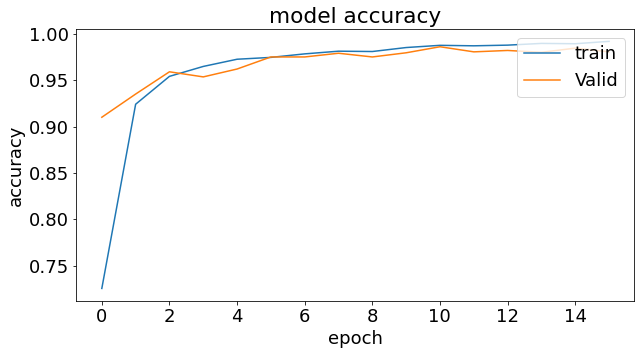

In [23]:
from matplotlib import pyplot as plt

print(learning_hist.history.keys())
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,5))

plt.plot(learning_hist.history['accuracy'])
plt.plot(learning_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()

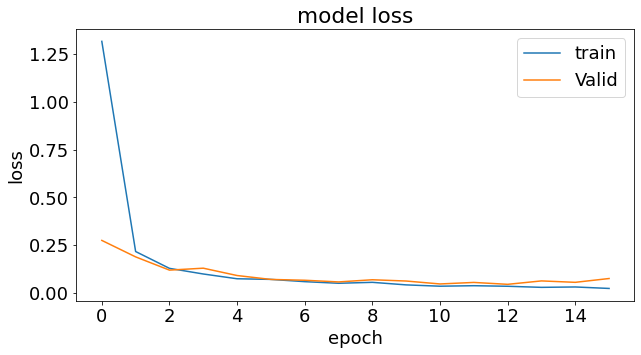

In [24]:
# summarize history for loss

from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 18})


plt.plot(learning_hist.history['loss'])
plt.plot(learning_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()